# Quranic Corpus Web Scraper 

This notebook scrapes all occurrences of "Allah" from the Quranic Arabic Corpus website.

**Data source:** https://corpus.quran.com/search.jsp?q=lem%3A%7Bll%7Eah+pos%3Apn

**Total results:** 2,699 occurrences across 54 pages


## 1. Install Required Libraries

Run this cell first to install the necessary packages.

In [1]:
!pip install requests beautifulsoup4 pandas matplotlib

## 2. Import Libraries

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from IPython.display import display, HTML

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 3. Define Scraping Function (FIXED)

In [3]:
def scrape_page(page_num, verbose=True):
    """
    Scrape a single page of results from the Quranic corpus.
    
    FIXED VERSION - Updated to match actual HTML structure:
    - Location is in <span class="l">
    - Transliteration is in <i class="ab">
    - Translation is in column 2 (<td class="c2">)
    - Arabic is in column 3 (<td class="c3">)
    
    Args:
        page_num (int): Page number to scrape
        verbose (bool): Print status messages
        
    Returns:
        list: List of dictionaries containing scraped data
    """
    url = f"https://corpus.quran.com/search.jsp?q=lem%3A%7Bll%7Eah+pos%3Apn&s=1&page={page_num}"
    
    if verbose:
        print(f"Scraping page {page_num}...", end=" ")
    
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        if verbose:
            print("✓")
    except requests.RequestException as e:
        if verbose:
            print(f"✗ Error: {e}")
        return []
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all table rows with class c1 (first column)
    results = []
    rows = soup.find_all('tr')
    
    for row in rows:
        # Look for rows with td.c1, td.c2, td.c3 structure
        c1 = row.find('td', class_='c1')
        c2 = row.find('td', class_='c2')
        c3 = row.find('td', class_='c3')
        
        if c1 and c2 and c3:
            # Extract location from <span class="l">
            location_span = c1.find('span', class_='l')
            if not location_span:
                continue
                
            location_text = location_span.get_text(strip=True)
            
            # Check if this is a result row (has location in parentheses)
            if location_text.startswith('(') and location_text.endswith(')'):
                location = location_text.strip('()')
                
                # Parse location into chapter:verse:word
                match = re.match(r'(\d+):(\d+):(\d+)', location)
                if match:
                    chapter = match.group(1)
                    verse = match.group(2)
                    word_position = match.group(3)
                else:
                    chapter = verse = word_position = location
                
                # Extract transliteration from <i class="ab">
                transliteration_tag = c1.find('i', class_='ab')
                transliteration = transliteration_tag.get_text(strip=True) if transliteration_tag else ""
                
                # Extract English translation from c2
                translation_link = c2.find('a')
                translation = translation_link.get_text(strip=True) if translation_link else c2.get_text(strip=True)
                
                # Extract Arabic text from c3
                arabic_text = c3.get_text(strip=True)
                
                results.append({
                    'location': location,
                    'chapter': chapter,
                    'verse': verse,
                    'word_position': word_position,
                    'transliteration': transliteration,
                    'translation': translation,
                    'arabic_verse': arabic_text
                })
    
    return results

print("✓ Scraping function defined (FIXED VERSION)")

✓ Scraping function defined (FIXED VERSION)


## 4. Test Scraping (Single Page)

Let's first test scraping a single page to make sure everything works.

In [4]:
# Test scraping page 1
print("Testing scraper with page 1...\n")
test_results = scrape_page(1)

print(f"\nResults found: {len(test_results)}")

if len(test_results) > 0:
    print("\n✓ Scraper is working!\n")
    print("Sample results:")
    print("=" * 80)
    for i in range(min(3, len(test_results))):
        result = test_results[i]
        print(f"\nResult {i+1}:")
        print(f"  Location: {result['location']}")
        print(f"  Chapter: {result['chapter']}, Verse: {result['verse']}, Word: {result['word_position']}")
        print(f"  Transliteration: {result['transliteration']}")
        print(f"  Translation: {result['translation']}")
        print(f"  Arabic: {result['arabic_verse'][:50]}...")
    print("\n" + "=" * 80)
    print("\n✓ Ready to scrape all pages!")
else:
    print("\n⚠️ WARNING: No results found!")
    print("\nPossible issues:")
    print("  1. Network connectivity problem")
    print("  2. Website is blocking automated requests")
    print("  3. Website structure has changed")
    print("\nPlease check the error messages above.")

Testing scraper with page 1...

Scraping page 1... ✓

Results found: 51

✓ Scraper is working!

Sample results:

Result 1:
  Location: 1:1:2
  Chapter: 1, Verse: 1, Word: 2
  Transliteration: l-lahi
  Translation: (of) Allah
  Arabic: بِسْمِاللَّهِالرَّحْمَٰنِ الرَّحِيمِ...

Result 2:
  Location: 1:1:2
  Chapter: 1, Verse: 1, Word: 2
  Transliteration: l-lahi
  Translation: (of) Allah
  Arabic: بِسْمِاللَّهِالرَّحْمَٰنِ الرَّحِيمِ...

Result 3:
  Location: 1:2:2
  Chapter: 1, Verse: 2, Word: 2
  Transliteration: lillahi
  Translation: (be) to Allah
  Arabic: الْحَمْدُلِلَّهِرَبِّ الْعَالَمِينَ...


✓ Ready to scrape all pages!


## 5. Scrape All Pages

**Note:** Only run this cell if the test above was successful!

This will scrape all 54 pages with a 1-second delay between requests.

In [5]:
# Initialize list to store all results
all_results = []

# Total number of pages (2699 results ÷ 50 per page = 54 pages)
total_pages = 54

print(f"Starting scrape of {total_pages} pages...\n")
print("=" * 50)

# Scrape each page
for page_num in range(1, total_pages + 1):
    results = scrape_page(page_num)
    all_results.extend(results)
    
    # Show progress every 10 pages
    if page_num % 10 == 0:
        print(f"Progress: {page_num}/{total_pages} pages ({len(all_results)} results so far)")
    
    # Be respectful - add a small delay between requests
    if page_num < total_pages:
        time.sleep(1)

print("=" * 50)
print(f"\n✓ Scraping complete!")
print(f"  Total results: {len(all_results)}")
print(f"  Expected: 2699")

if len(all_results) < 2699:
    print(f"\n⚠️ Warning: Got fewer results than expected ({len(all_results)} vs 2699)")
elif len(all_results) >= 2699:
    print(f"\n✓ Success! Got expected number of results.")

Starting scrape of 54 pages...

Scraping page 1... ✓
Scraping page 2... ✓
Scraping page 3... ✓
Scraping page 4... ✓
Scraping page 5... ✓
Scraping page 6... ✓
Scraping page 7... ✓
Scraping page 8... ✓
Scraping page 9... ✓
Scraping page 10... ✓
Progress: 10/54 pages (510 results so far)
Scraping page 11... ✓
Scraping page 12... ✓
Scraping page 13... ✓
Scraping page 14... ✓
Scraping page 15... ✓
Scraping page 16... ✓
Scraping page 17... ✓
Scraping page 18... ✓
Scraping page 19... ✓
Scraping page 20... ✓
Progress: 20/54 pages (1020 results so far)
Scraping page 21... ✓
Scraping page 22... ✓
Scraping page 23... ✓
Scraping page 24... ✓
Scraping page 25... ✓
Scraping page 26... ✓
Scraping page 27... ✓
Scraping page 28... ✓
Scraping page 29... ✓
Scraping page 30... ✓
Progress: 30/54 pages (1530 results so far)
Scraping page 31... ✓
Scraping page 32... ✓
Scraping page 33... ✓
Scraping page 34... ✓
Scraping page 35... ✓
Scraping page 36... ✓
Scraping page 37... ✓
Scraping page 38... ✓
Scraping p

## 6. Create DataFrame

In [6]:
# Convert to pandas DataFrame
df = pd.DataFrame(all_results)

# Check if data was scraped successfully
if len(df) == 0:
    print("⚠️ WARNING: No data was scraped!")
    print("\nPlease go back and check:")
    print("  1. The test scraping cell (cell 4)")
    print("  2. Any error messages in the scraping cell (cell 5)")
else:
    # Display basic information
    print(f"✓ DataFrame created successfully!\n")
    print(f"Total rows: {len(df)}")
    print(f"Columns: {', '.join(df.columns)}")
    print(f"\nData types:")
    print(df.dtypes)
    print(f"\nFirst 3 entries:")
    display(df.head(3))

✓ DataFrame created successfully!

Total rows: 2753
Columns: location, chapter, verse, word_position, transliteration, translation, arabic_verse

Data types:
location           object
chapter            object
verse              object
word_position      object
transliteration    object
translation        object
arabic_verse       object
dtype: object

First 3 entries:


,location,chapter,verse,word_position,transliteration,translation,arabic_verse
0,1:1:2,1,1,2,l-lahi,(of) Allah,بِسْمِاللَّهِالرَّحْمَٰنِ الرَّحِيمِ
1,1:1:2,1,1,2,l-lahi,(of) Allah,بِسْمِاللَّهِالرَّحْمَٰنِ الرَّحِيمِ
2,1:2:2,1,2,2,lillahi,(be) to Allah,الْحَمْدُلِلَّهِرَبِّ الْعَالَمِينَ


## 7. Preview the Data

In [7]:
if len(df) > 0:
    # Display first 10 rows
    print("First 10 rows:")
    display(df.head(10))
else:
    print("⚠️ No data to display")

First 10 rows:


,location,chapter,verse,word_position,transliteration,translation,arabic_verse
0,1:1:2,1,1,2,l-lahi,(of) Allah,بِسْمِاللَّهِالرَّحْمَٰنِ الرَّحِيمِ
1,1:1:2,1,1,2,l-lahi,(of) Allah,بِسْمِاللَّهِالرَّحْمَٰنِ الرَّحِيمِ
2,1:2:2,1,2,2,lillahi,(be) to Allah,الْحَمْدُلِلَّهِرَبِّ الْعَالَمِينَ
3,2:7:2,2,7,2,l-lahu,Allah,خَتَمَاللَّهُعَلَىٰ قُلُوبِهِمْ وَعَلَىٰ سَمْع...
4,2:8:6,2,8,6,bil-lahi,in Allah,وَمِنَ النَّاسِ مَنْ يَقُولُ آمَنَّابِاللَّهِو...
5,2:9:2,2,9,2,l-laha,Allah,يُخَادِعُونَاللَّهَوَالَّذِينَ آمَنُوا وَمَا ي...
6,2:10:5,2,10,5,l-lahu,Allah,فِي قُلُوبِهِمْ مَرَضٌ فَزَادَهُمُاللَّهُمَرَضًا
7,2:15:1,2,15,1,al-lahu,Allah,اللَّهُيَسْتَهْزِئُ بِهِمْ وَيَمُدُّهُمْ فِي ط...
8,2:17:11,2,17,11,l-lahu,Allah,فَلَمَّا أَضَاءَتْ مَا حَوْلَهُ ذَهَبَاللَّهُب...
9,2:19:17,2,19,17,wal-lahu,And Allah,وَاللَّهُمُحِيطٌ بِالْكَافِرِينَ


In [8]:
if len(df) > 0:
    # Display last 10 rows
    print("Last 10 rows:")
    display(df.tail(10))
else:
    print("⚠️ No data to display")

Last 10 rows:


,location,chapter,verse,word_position,transliteration,translation,arabic_verse
2743,95:8:2,95,8,2,l-lahu,Allah,أَلَيْسَاللَّهُبِأَحْكَمِ الْحَاكِمِينَ
2744,96:14:4,96,14,4,l-laha,Allah,أَلَمْ يَعْلَمْ بِأَنَّاللَّهَيَرَىٰ
2745,98:2:3,98,2,3,l-lahi,Allah,رَسُولٌ مِنَاللَّهِيَتْلُو صُحُفًا مُطَهَّرَةً
2746,98:5:5,98,5,5,l-laha,Allah,وَمَا أُمِرُوا إِلَّا لِيَعْبُدُوااللَّهَمُخْل...
2747,98:8:14,98,8,14,l-lahu,Allah,رَضِيَاللَّهُعَنْهُمْ وَرَضُوا عَنْهُ ذَٰلِكَ ...
2748,104:6:2,104,6,2,l-lahi,Allah,نَارُاللَّهِالْمُوقَدَةُ
2749,110:1:4,110,1,4,l-lahi,(of) Allah,إِذَا جَاءَ نَصْرُاللَّهِوَالْفَتْحُ
2750,110:2:6,110,2,6,l-lahi,(of) Allah,وَرَأَيْتَ النَّاسَ يَدْخُلُونَ فِي دِينِاللَّ...
2751,112:1:3,112,1,3,l-lahu,(is) Allah,قُلْ هُوَاللَّهُأَحَدٌ
2752,112:2:1,112,2,1,al-lahu,Allah,اللَّهُالصَّمَدُ


## 8. Data Analysis

Let's do some basic analysis of the data.

In [9]:
if len(df) > 0:
    # Count occurrences by chapter
    chapter_counts = df['chapter'].value_counts().sort_index()
    print("Occurrences of 'Allah' by Chapter (Surah):")
    print("=" * 50)
    print(chapter_counts.head(20))
else:
    print("⚠️ No data available for analysis")

Occurrences of 'Allah' by Chapter (Surah):
chapter
1        3
10      62
104      1
11      39
110      2
112      2
12      45
13      35
14      37
15       2
16      86
17      10
18      16
19       9
2      287
20       6
21       6
22      76
23      14
24      81
Name: count, dtype: int64


In [10]:
if len(df) > 0:
    # Count different transliterations
    transliteration_counts = df['transliteration'].value_counts()
    print("Most common transliterations:")
    print("=" * 50)
    print(transliteration_counts.head(10))
else:
    print("⚠️ No data available for analysis")

Most common transliterations:
transliteration
l-lahi       846
l-lahu       716
l-laha       601
wal-lahu     245
bil-lahi     142
lillahi      117
al-lahu       32
walillahi     27
tal-lahi       8
fal-lahu       6
Name: count, dtype: int64


In [11]:
if len(df) > 0:
    # Count different translations
    translation_counts = df['translation'].value_counts()
    print("Most common translations:")
    print("=" * 50)
    print(translation_counts.head(10))
else:
    print("⚠️ No data available for analysis")

Most common translations:
translation
Allah         1335
(of) Allah     366
And Allah      198
in Allah        84
(by) Allah      60
(is) Allah      44
to Allah        37
and Allah       30
for Allah       20
(to) Allah      19
Name: count, dtype: int64


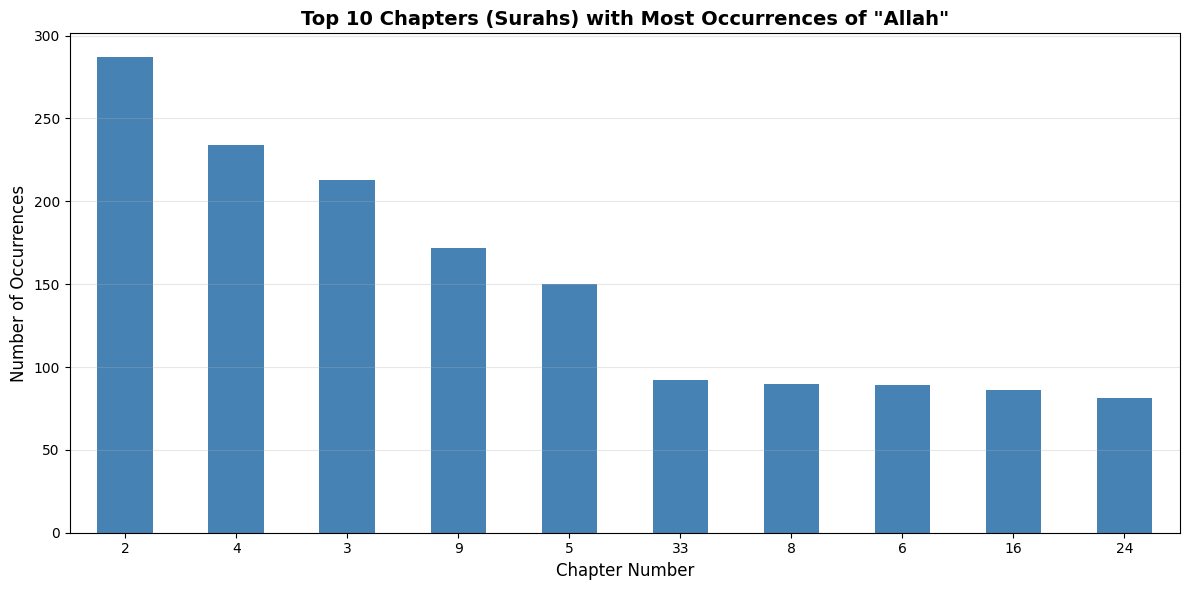

In [12]:
if len(df) > 0:
    # Top 10 chapters with most occurrences
    import matplotlib.pyplot as plt
    
    top_chapters = df['chapter'].value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    top_chapters.plot(kind='bar', color='steelblue')
    plt.title('Top 10 Chapters (Surahs) with Most Occurrences of "Allah"', fontsize=14, fontweight='bold')
    plt.xlabel('Chapter Number', fontsize=12)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No data available for visualization")

## 9. Save to CSV

In [13]:
if len(df) > 0:
    # Save to CSV file
    output_file = '/kaggle/working/quran_corpus_allah_complete.csv'
    df.to_csv(output_file, index=False, encoding='utf-8')
    
    print(f"✓ Data saved to '{output_file}'")
    print(f"  Total rows: {len(df)}")
    print(f"  Columns: {', '.join(df.columns)}")
    print(f"\n✓ You can download this file from the Kaggle 'Output' tab")
else:
    print("⚠️ No data to save. Please check the scraping steps above.")

✓ Data saved to '/kaggle/working/quran_corpus_allah_complete.csv'
  Total rows: 2753
  Columns: location, chapter, verse, word_position, transliteration, translation, arabic_verse

✓ You can download this file from the Kaggle 'Output' tab


## 10. Export to Excel (Optional)

In [14]:
# Uncomment the lines below to save as Excel file:
# !pip install openpyxl
# if len(df) > 0:
#     df.to_excel('/kaggle/working/quran_corpus_allah_complete.xlsx', index=False, engine='openpyxl')
#     print("✓ Data saved to '/kaggle/working/quran_corpus_allah_complete.xlsx'")
# else:
#     print("⚠️ No data to save")

## 11. Search and Filter Examples

Here are some examples of how to search and filter the data.

In [15]:
if len(df) > 0:
    # Find all occurrences in a specific chapter (e.g., Chapter 2 - Al-Baqarah)
    chapter_2 = df[df['chapter'] == '2']
    print(f"Occurrences in Chapter 2 (Al-Baqarah): {len(chapter_2)}")
    display(chapter_2.head())
else:
    print("⚠️ No data available")

Occurrences in Chapter 2 (Al-Baqarah): 287


,location,chapter,verse,word_position,transliteration,translation,arabic_verse
3,2:7:2,2,7,2,l-lahu,Allah,خَتَمَاللَّهُعَلَىٰ قُلُوبِهِمْ وَعَلَىٰ سَمْع...
4,2:8:6,2,8,6,bil-lahi,in Allah,وَمِنَ النَّاسِ مَنْ يَقُولُ آمَنَّابِاللَّهِو...
5,2:9:2,2,9,2,l-laha,Allah,يُخَادِعُونَاللَّهَوَالَّذِينَ آمَنُوا وَمَا ي...
6,2:10:5,2,10,5,l-lahu,Allah,فِي قُلُوبِهِمْ مَرَضٌ فَزَادَهُمُاللَّهُمَرَضًا
7,2:15:1,2,15,1,al-lahu,Allah,اللَّهُيَسْتَهْزِئُ بِهِمْ وَيَمُدُّهُمْ فِي ط...


In [16]:
if len(df) > 0:
    # Find all occurrences with a specific transliteration (e.g., "l-lahu")
    l_lahu = df[df['transliteration'] == 'l-lahu']
    print(f"Occurrences of 'l-lahu': {len(l_lahu)}")
    display(l_lahu.head())
else:
    print("⚠️ No data available")

Occurrences of 'l-lahu': 716


,location,chapter,verse,word_position,transliteration,translation,arabic_verse
3,2:7:2,2,7,2,l-lahu,Allah,خَتَمَاللَّهُعَلَىٰ قُلُوبِهِمْ وَعَلَىٰ سَمْع...
6,2:10:5,2,10,5,l-lahu,Allah,فِي قُلُوبِهِمْ مَرَضٌ فَزَادَهُمُاللَّهُمَرَضًا
8,2:17:11,2,17,11,l-lahu,Allah,فَلَمَّا أَضَاءَتْ مَا حَوْلَهُ ذَهَبَاللَّهُب...
10,2:20:16,2,20,16,l-lahu,Allah,وَلَوْ شَاءَاللَّهُلَذَهَبَ بِسَمْعِهِمْ وَأَب...
15,2:26:26,2,26,26,l-lahu,Allah,وَأَمَّا الَّذِينَ كَفَرُوا فَيَقُولُونَ مَاذَ...


In [17]:
if len(df) > 0:
    # Search for specific translation (e.g., "in Allah")
    in_allah = df[df['translation'].str.contains('in Allah', case=False, na=False)]
    print(f"Occurrences with 'in Allah' translation: {len(in_allah)}")
    display(in_allah.head())
else:
    print("⚠️ No data available")

Occurrences with 'in Allah' translation: 86


,location,chapter,verse,word_position,transliteration,translation,arabic_verse
4,2:8:6,2,8,6,bil-lahi,in Allah,وَمِنَ النَّاسِ مَنْ يَقُولُ آمَنَّابِاللَّهِو...
18,2:28:3,2,28,3,bil-lahi,in Allah,كَيْفَ تَكْفُرُونَبِاللَّهِوَكُنْتُمْ أَمْوَات...
23,2:62:10,2,62,10,bil-lahi,in Allah,مَنْ آمَنَبِاللَّهِوَالْيَوْمِ الْآخِرِ وَعَمِ...
26,2:67:16,2,67,16,bil-lahi,in Allah,قَالَ أَعُوذُبِاللَّهِأَنْ أَكُونَ مِنَ الْجَا...
78,2:126:16,2,126,16,bil-lahi,in Allah,وَارْزُقْ أَهْلَهُ مِنَ الثَّمَرَاتِ مَنْ آمَن...


## Summary

This notebook has:
1. Scraped all occurrences of "Allah" from the Quranic Arabic Corpus
2. Organized the data into a structured format
3. Performed basic analysis
4. Saved the data to CSV format

**CSV Columns:**
- `location` - Full location reference (e.g., "1:1:2")
- `chapter` - Surah number
- `verse` - Ayah number
- `word_position` - Position of the word in the verse
- `transliteration` - Romanized Arabic
- `translation` - English gloss
- `arabic_verse` - Full Arabic text of the verse

**FIXED VERSION:** This version correctly parses the HTML structure:
- Finds location in `<span class="l">`
- Finds transliteration in `<i class="ab">`
- Correctly identifies table cells by class names (c1, c2, c3)